In [1]:
import sys
sys.path.append('../')
sys.path.append("../scripts/")
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.linear_model import LinearRegression
import data_loader_mante as dlm

/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
dataset = dlm.ManteDataset(monkey='A', bin_width=5, smoothing_width=50, cavg=True)

Loading data for monkey A
loaded 762 units, binned at 5.0ms


/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  

Averaging over 144 conditions


/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  

In [3]:
# Defining some useful variables
print('Dataset shape: ', dataset.data_avg.shape)
n_conds, n_time, n_units_total = dataset.data_avg.shape

correct_trials = dataset.conditions.correct == 1

# Selecting neurons that have at least one trial for each correct condition
good_neurons = ~np.any(dataset.ntrials[correct_trials] == 0, axis=0)
n_units = good_neurons.sum()
print('Number of neurons exhibiting all conditions: ', n_units)

X_all = dataset.data_avg[:, :, good_neurons]
X = dataset.data_avg[correct_trials][:, :, good_neurons]
print('Cleaned dataset shape: ', X.shape)

Dataset shape:  (144, 150, 762)
Number of neurons exhibiting all conditions:  727
Cleaned dataset shape:  (72, 150, 727)


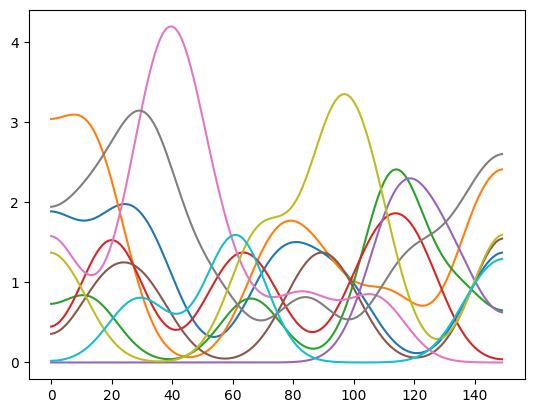

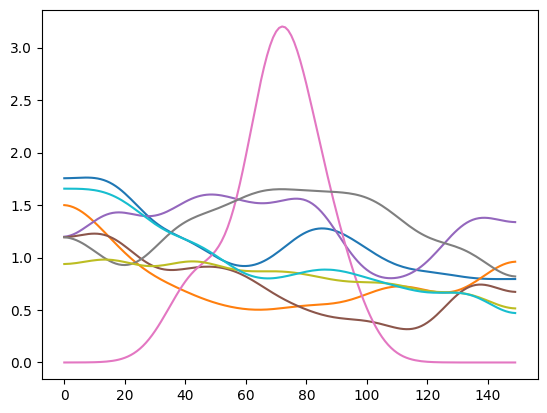

In [4]:
# Showing single unit, single trial trajectories, and then some condition-averaged ones
# unit = 0
unit = random.randint(0, n_units_total)
rand_trials = random.sample(range(dataset.units[unit].response.shape[0]), 10)
for trial in rand_trials:
    plt.plot(dataset.units[unit].response[trial])
plt.show()

rand_conds = random.sample(range(n_conds), 10)
for cond in rand_conds:
    plt.plot(dataset.data_avg[cond, :, unit])
plt.show()

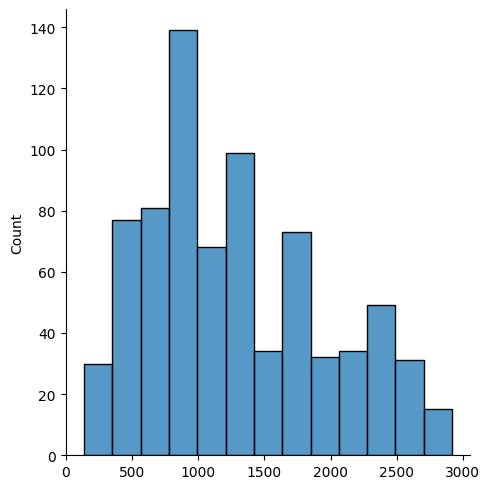

In [5]:
# Number of trials per unit
Ntrials = [unit.response.shape[0] for unit in dataset.units]
sns.displot(Ntrials)

# Looking at some condition-averaged trajectories

In [6]:
choice = dataset.conditions[correct_trials]['choice']
context = dataset.conditions[correct_trials]['context']
direction = dataset.conditions[correct_trials]['stim_dir_lvl']
color = dataset.conditions[correct_trials]['stim_col_lvl']

In [7]:
dataset.conditions["prev_choice"] = np.roll(dataset.conditions["choice"],1)
dataset.conditions["prev_color"] = np.roll(dataset.conditions["stim_col"],1)
dataset.conditions["prev_dir"] = np.roll(dataset.conditions["stim_dir"],1)

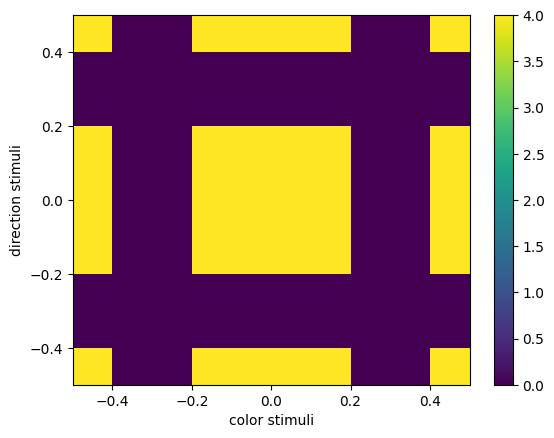

In [8]:
plt.hist2d(dataset.conditions.stim_col,dataset.conditions.stim_dir)
plt.xlabel("color stimuli")
plt.ylabel("direction stimuli")
plt.colorbar()

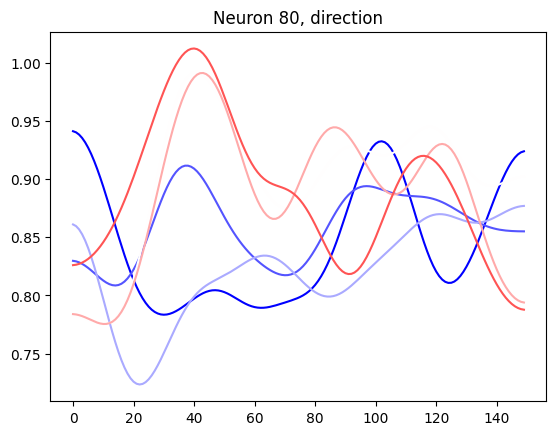

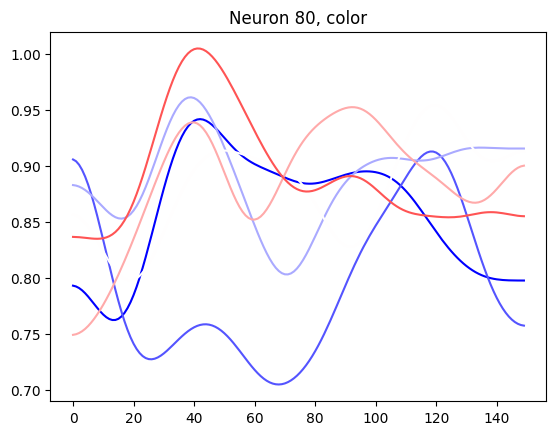

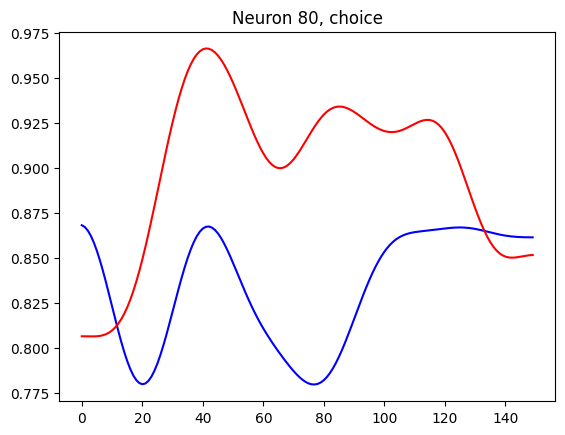

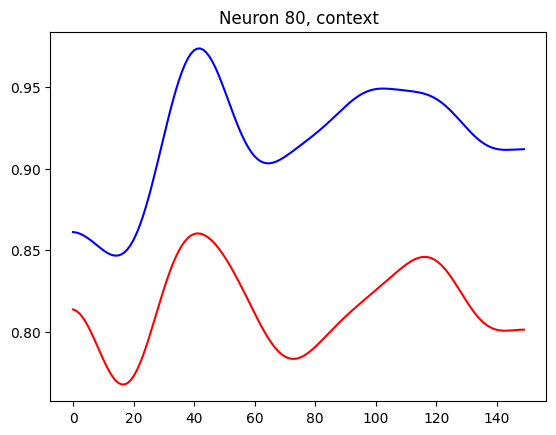

In [9]:
# see selectivity to direction
# unit = 5
unit = random.randint(0, n_units)

for i in np.unique(direction):
    plt.plot(X[direction == i, :, unit].mean(axis=0), c=cm.bwr(i / 6))
plt.title(f'Neuron {unit}, direction')
plt.show()

for i in np.unique(color):
    plt.plot(X[color == i, :, unit].mean(axis=0), c=cm.bwr(i / 6))
plt.title(f'Neuron {unit}, color')
plt.show()

for i in np.unique(choice):
    plt.plot(X[choice == i, :, unit].mean(axis=0), c=cm.bwr((i+1)/2))
plt.title(f'Neuron {unit}, choice')
plt.show()

for i in np.unique(context):
    plt.plot(X[context == i, :, unit].mean(axis=0), c=cm.bwr((i+1)/2))
plt.title(f'Neuron {unit}, context')
plt.show()

# Code for TDR

In [10]:
to_decode_vars = ['stim_dir', 'stim_col','choice']

all_betas = []

for ctx_idx in [context!=0, context==-1,context==1]:

    conditions_regressors = dataset.conditions[correct_trials][to_decode_vars].to_numpy()
    conditions_regressors = conditions_regressors[ctx_idx]

    X_mean = np.mean(X[ctx_idx], axis=(0, 1))
    X_flat = X[ctx_idx] - X_mean
    X_percond = X_flat.reshape((conditions_regressors.shape[0], -1))
    print(conditions_regressors.shape)
    print(X_percond.shape)
    # Linear regression
    linmodel = LinearRegression(fit_intercept=True)
    linmodel = linmodel.fit(conditions_regressors, X_percond)

    betas = linmodel.coef_.T.reshape((len(to_decode_vars), n_time, -1))
    intercepts = linmodel.intercept_.T.reshape((n_time, -1))
    betas = np.concatenate([betas, intercepts[np.newaxis, :, :]], axis=0)
    print(betas.shape)

    all_betas.append(betas)

(72, 3)
(72, 109050)
(4, 150, 727)
(36, 3)
(36, 109050)
(4, 150, 727)
(36, 3)
(36, 109050)
(4, 150, 727)


Text(0.5, 0, 'time (dt=5ms)')

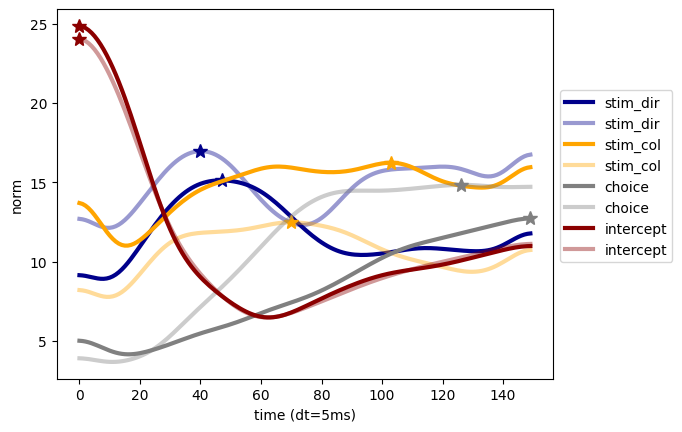

In [11]:
# print norm of the vectors and identify t_max
colors = ['darkblue','orange','gray','darkred']
lines = ['-','-','--']
alphas = [1,0.4,0.4]

tmaxes = []
labels = to_decode_vars.copy()
labels.append('intercept')
for i in range(len(labels)):
    for b,betas in enumerate(all_betas[1:]):
        norms = np.linalg.norm(betas[i], axis=1)
        plt.plot(norms, label=labels[i], c=colors[i],lw=3,ls=lines[b],alpha=alphas[b])
        tmaxes.append(np.argmax(norms))
        plt.plot([tmaxes[-1]], [norms[tmaxes[-1]]], marker='*', c=colors[i], markersize=10)
plt.legend(bbox_to_anchor=(1, .8))
plt.ylabel('norm')
plt.xlabel('time (dt=5ms)')

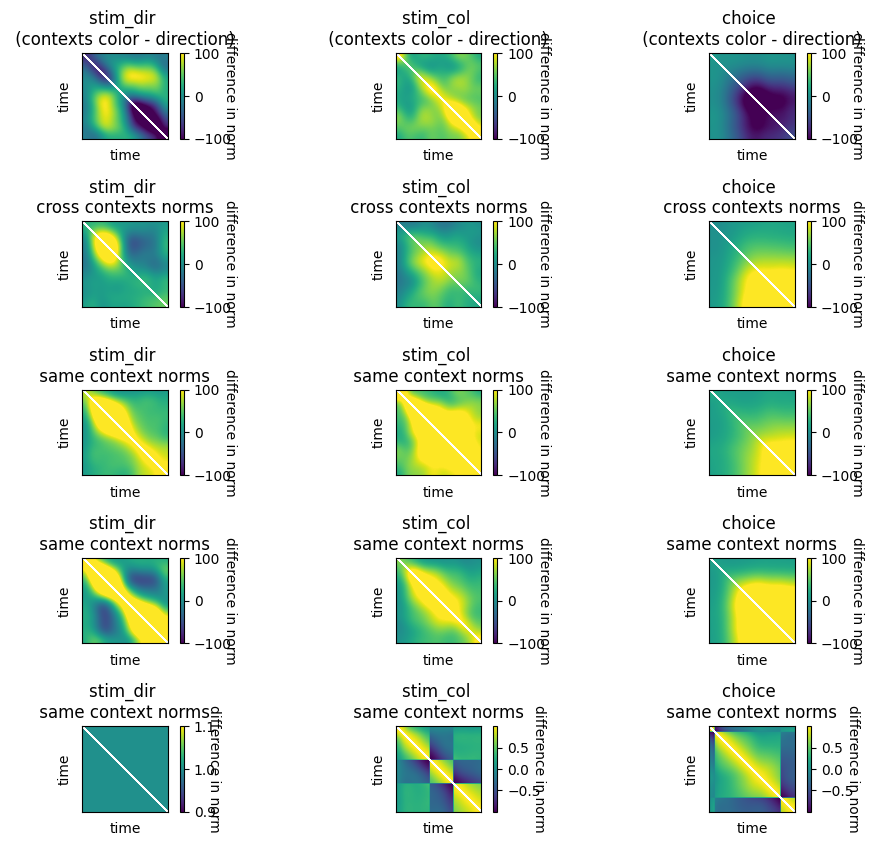

In [12]:
all_betas_norm = all_betas/np.linalg.norm(all_betas,axis=3)[:,:,:,None]

diff_norms = [(all_betas[1][c] @ all_betas[1][c].T) - (all_betas[2][c] @ all_betas[2][c].T) for c in range(len(labels))]

cross_norms = [all_betas[1][c] @ all_betas[2][c].T for c in range(len(labels))]

same_norms_1 = [all_betas[1][c] @ all_betas[1][c].T for c in range(len(labels))]

same_norms_2 = [all_betas[2][c] @ all_betas[2][c].T for c in range(len(labels))]


all_betas_orth = []
for t in range(150): # time
    choice_axis = all_betas[0][2,100]
    Bmat = np.vstack([choice_axis, all_betas[0][0,t], all_betas[0][1,t]]).T
    BmatQ, _ = np.linalg.qr(Bmat)
    all_betas_orth.append(BmatQ)

all_betas_orth = np.einsum('ijk -> kij',all_betas_orth)

plt.figure(figsize=(10,10))
for i in range(len(labels)-1):
    #plt.figure()


    plt.subplot(6,3,i+1)
    plt.title("%s \n (contexts color - direction) " % labels[i])
    np.fill_diagonal(diff_norms[i],np.nan)
    plt.imshow(diff_norms[i],vmax=100,vmin=-100)
    cbar=plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('difference in norm', rotation=270)

    plt.xlabel("time")
    plt.ylabel("time")
    plt.xticks([])
    plt.yticks([])


    plt.subplot(6,3,3+ i+1)
    plt.title("%s \n cross contexts norms " % labels[i])
    np.fill_diagonal(cross_norms[i],np.nan)
    plt.imshow(cross_norms[i],vmax=100,vmin=-100)
    cbar=plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('difference in norm', rotation=270)

    plt.xlabel("time")
    plt.ylabel("time")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(6,3,6+i+1)
    plt.title("%s \n same context norms " % labels[i])
    np.fill_diagonal(same_norms_1[i],np.nan)
    plt.imshow(same_norms_1[i],vmax=100,vmin=-100)
    cbar=plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('difference in norm', rotation=270)

    plt.xlabel("time")
    plt.ylabel("time")
    plt.xticks([])
    plt.yticks([])


    plt.subplot(6,3,9+i+1)
    plt.title("%s \n same context norms " % labels[i])
    np.fill_diagonal(same_norms_2[i],np.nan)
    plt.imshow(same_norms_2[i],vmax=100,vmin=-100)
    cbar=plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('difference in norm', rotation=270)

    plt.xlabel("time")
    plt.ylabel("time")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(6,3,12+i+1)
    plt.title("%s \n same context norms " % labels[i])
    orth_norm = all_betas_orth[i] @ all_betas_orth[i].T
    np.fill_diagonal(orth_norm,np.nan)
    plt.imshow(orth_norm)
    cbar=plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('difference in norm', rotation=270)

    plt.xlabel("time")
    plt.ylabel("time")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [13]:
# # Choose timepoints for the axes, orthogonalize

beta_choice = betas[0, tmaxes[0]]
beta_motion = betas[1, tmaxes[1]]
beta_color = betas[2, tmaxes[2]]
beta_context = betas[3, tmaxes[3]]
Bmat = np.vstack([beta_choice, beta_motion, beta_color, beta_context]).T
print(Bmat.shape)
BmatQ, _ = np.linalg.qr(Bmat)
beta_choice = BmatQ[:, 0]
beta_motion = BmatQ[:, 1]
beta_color = BmatQ[:, 2]
beta_context = BmatQ[:, 3]

(727, 4)


## And the famous TDR visualizations

Note: it's better when the entire intercept is removed

In [14]:
# TODO formalize in a file
def conditions_averaged_plot(data, conditions, ax1, ax2, colors):
    for cond, col in zip(conditions, colors):
        tensor_tmp = data[cond].mean(axis=0)  # Averaging across all conditions that match the constraints
        plt.plot(tensor_tmp @ ax1, tensor_tmp @ ax2, c=col)
        plt.plot(tensor_tmp[0] @ ax1, tensor_tmp[0] @ ax2, marker='o', c=col)

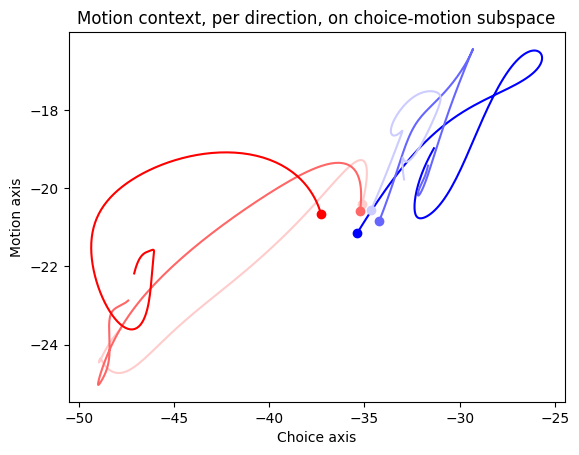

In [15]:
plt.title('Motion context, per direction, on choice-motion subspace')
plt.xlabel('Choice axis')
plt.ylabel('Motion axis')

conditions_plot = [((direction == i) & (context == 1)) for i in range(0, 6)]
colors_plot = [cm.bwr(i/5) for i in range(0, 6)]

conditions_averaged_plot(X, conditions_plot, beta_choice, beta_motion, colors_plot)

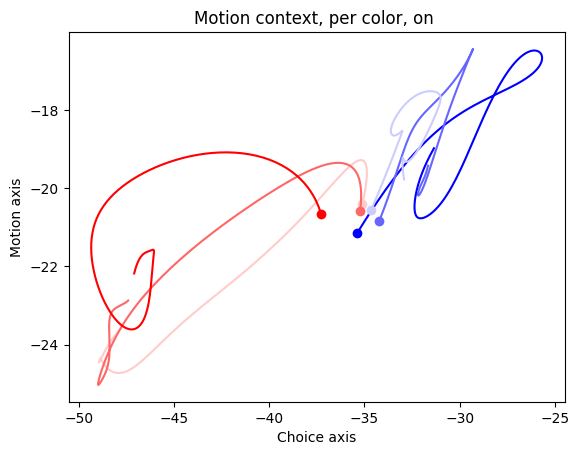

In [16]:
plt.title('Motion context, per color, on ')
plt.xlabel('Choice axis')
plt.ylabel('Motion axis')

conditions_averaged_plot(X, conditions_plot, beta_choice, beta_motion, colors_plot)